# Breast Cancer prediction
- Goal: to predict breast cancer based on 10 features desribing characteristics of the cell
- Wisconsin Diagnostic Breast Cancer (WDBC): 10 features computed from a digitized image of a fine needle aspirate (FNA) of a breast mass
- original paper documented 97% accuracy with a multisurface method-tree (mentioned extreme values of area, smoothnes & texture)

NB. NHS currently uses the Cox proportional hazards regression model to predict breast cancer (https://breast.predict.nhs.uk/about/technical/technical)

## Initialisation

In [2]:
# Import core libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pydot
from IPython.display import Image

# Import ML & stats libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import (roc_auc_score, confusion_matrix, roc_curve, accuracy_score, precision_score, classification_report)

# to display multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Import data
df = pd.read_csv("data.csv")

## Overview of the data

In [4]:
print("Data shape: " + str(df.shape))
df.info()

Data shape: (569, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  peri

In [5]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [6]:
df.describe(include='all')

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.037183e+07,NaN,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,NaN,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,NaN,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,NaN,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,NaN,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,NaN,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN


### Observations
- class label which needs to be predicted (y) = diagnosis - a supervised classification problem
- all features seem to be have correct data type 
- no missing/null values

### To do
- the  first (ID which cannot be used for classification) & last column (unnamed: 32) can be removed
- one-hot encode diagnosis for modelling
- potentially linearity/redundancy in features (ex. mean, SEM, worst for the same features) - PCA to reduce dimensionality


## Pre-processing

In [7]:
# remove meaningless variables
df = df.drop(['id'], axis=1)
df = df.drop(['Unnamed: 32'], axis=1)

## Data exploration and visualisation

Number of Benign:  357   62.7 %
Number of Malignant:  212   37.3 %


Text(0.5, 1.0, 'Number of Malignant vs Benign Tumours')

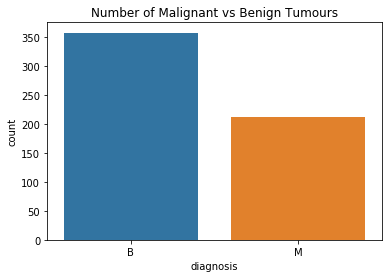

In [8]:
# Benign vs Malignant ratio
B_counts, M_counts = df['diagnosis'].value_counts()
B_percent, M_percent = (df['diagnosis'].value_counts(normalize=True))*100

print('Number of Benign: ', B_counts, ' ', round(B_percent,1), '%')
print('Number of Malignant: ',M_counts, ' ', round(M_percent,1), '%')

ax = sns.countplot(x='diagnosis', data=df, order=df['diagnosis'].value_counts().index)
plt.title('Number of Malignant vs Benign Tumours')

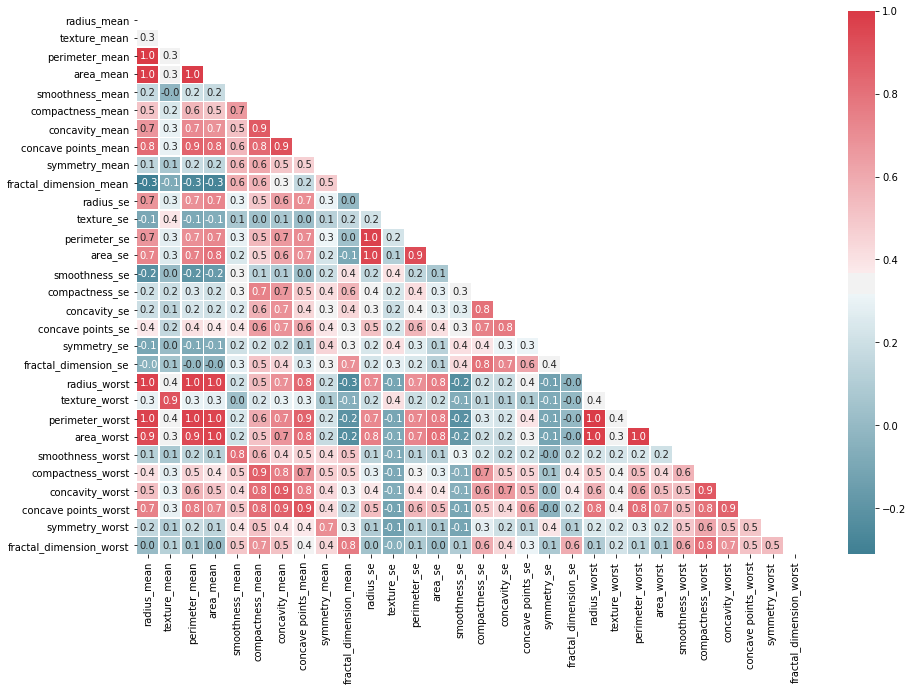

In [9]:
# Correlation matrix & map
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#correlation map
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.corr(), mask=mask, cmap=cmap, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [10]:
# Box plot
features_mean = df.columns[1:11] 
features_se = df.columns[11:21]
features_worst = df.columns[21:31]

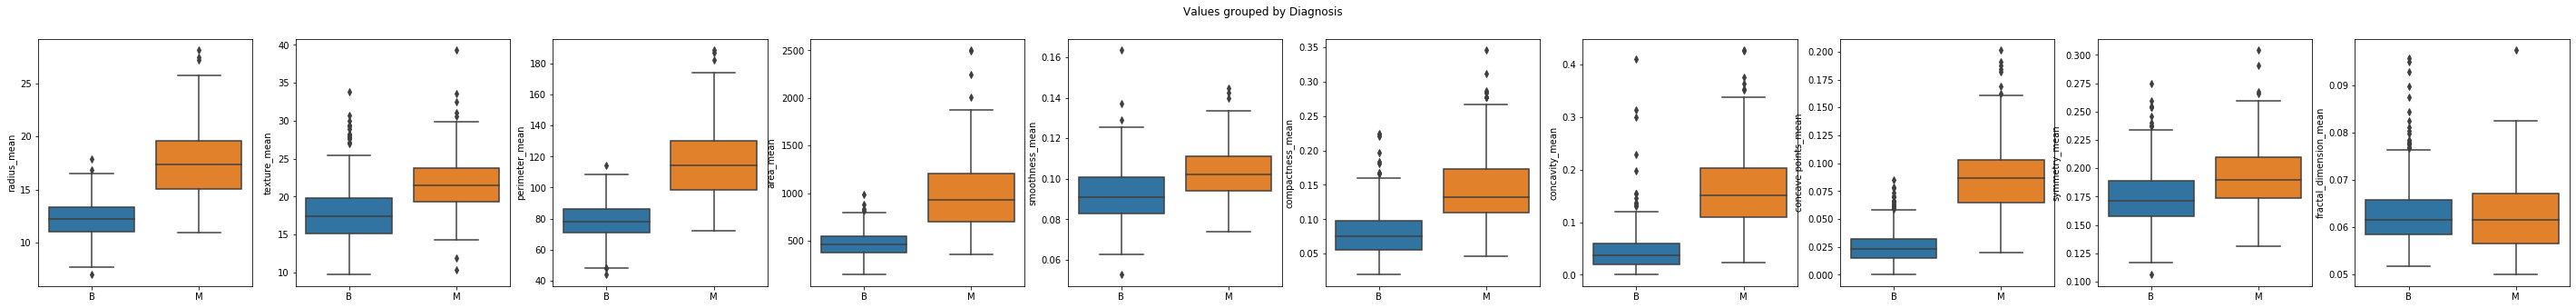

In [11]:
def boxplot_features(features_list):
    f,axis = plt.subplots(1,10,figsize = (50,5))
    f.suptitle('Values grouped by Diagnosis')
    for i, feature in enumerate(features_list,1):
        boxplot = sns.boxplot(x='diagnosis', y=feature, data=df,order=['B','M'],ax=axis[i-1]).set(xlabel='')

boxplot_features(features_mean)
#boxplot_features(features_se)
#boxplot_features(features_worst)

- seems like malignant tumours tend to have higher values for most features
- presence of redundancy and/or multicolinearity shown by
    - almost perfect linear correlation betwen radius (r) , perimeter (2πr) & area (πr^2) - not surprising as they are mathematically related
    - concavity & concave points
 - can be resolved by performing dimensionality reduction (PCA)

## Feature engineering & selection

In [12]:
# split data into X (features) & y (diagnosis) and convert y into binary
X = df.drop('diagnosis', axis = 1)

df.loc[df['diagnosis'] == 'B', 'diagnosis'] = 0
df.loc[df['diagnosis'] == 'M', 'diagnosis'] = 1
df['diagnosis'] = df['diagnosis'].astype(int)
y = df['diagnosis']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=33)

### PCA

In [14]:
# Standardisation for PCA
scale = StandardScaler().fit(X_train) # fitting standardisation on the training set only

# apply standardisation to both training & test set
X_train_norm = scale.transform(X_train)
X_test_norm = scale.transform(X_test)

In [15]:
pca = PCA().fit(X_train_norm) # fitting an empty PCA on the training set only

Text(0.5, 0, 'Number of PCs')

Text(0, 0.5, 'Variance explained')

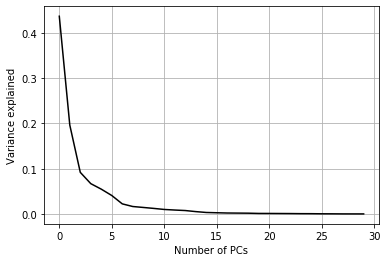

In [16]:
# To decide on the number of PCs - variance explained
var_explained = pca.explained_variance_ratio_
plt.plot(var_explained, color='black')
plt.xlabel('Number of PCs')
plt.ylabel('Variance explained')
plt.grid()

Text(0.5, 0, 'Number of PCs')

Text(0, 0.5, 'Cumulative variance explaind')

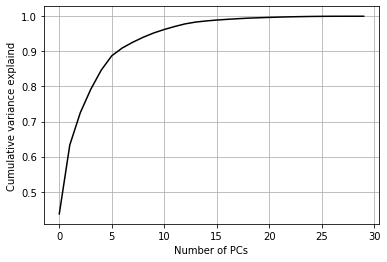

In [17]:
# To decide on the number of PCs - scree plot
var_cum = np.cumsum(var_explained)
plt.plot(var_cum, color='black')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative variance explaind')
plt.grid()

In [18]:
# decided to perform PCA with 10 components which explain more than 95% of the variance in data
pca = PCA(n_components=10).fit(X_train_norm)

# apply the mapping/transformation to both training & test set
X_train_PCA = pca.transform(X_train_norm)
X_test_PCA = pca.transform(X_test_norm)

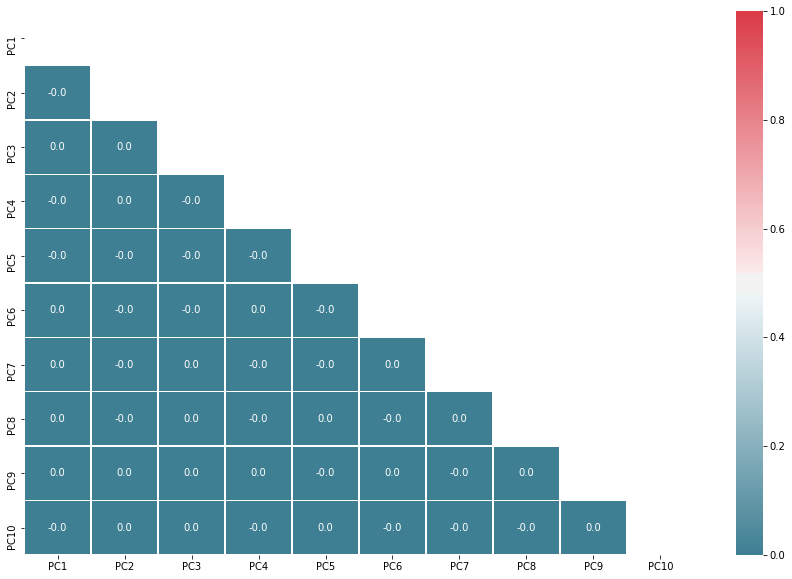

In [19]:
# correlation matrix after PCA to check that no correlation/redundancy exist
features_pca = ['PC'+str(i+1) for i in range(pca.n_components)]
df_pca = pd.DataFrame(X_train_PCA, columns=features_pca)

mask = np.zeros_like(df_pca.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#correlation map
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_pca.corr(), mask=mask, cmap=cmap, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

## Modelling - classifier (categorical & supervised)
### 1.logistic regression 
    1.1) without PCA 
    1.2) with PCA
- used to predict the probability of a categorical variable via an exponential function

In [20]:
# 1.1) Base model - logistic regression without PCA
# Use standardised data to be able to look at feature importance
logit = LogisticRegression(random_state=33) 
logit.fit(X_train_norm, y_train)

# Predict labels & probabilities on test set
pred_logit = logit.predict(X_test_norm) 
proba_logit = logit.predict_proba(X_test_norm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=33, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
# 1.2) logistic regression with PCA
logit_PCA = LogisticRegression(random_state = 33)
logit_PCA.fit(X_train_PCA, y_train)

pred_logit_PCA = logit_PCA.predict(X_test_PCA) 
proba_logit_PCA = logit_PCA.predict_proba(X_test_PCA)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=33, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Text(0.5, 0, 'Feature importance')

Text(0.5, 1.0, 'Feature importance for logistic regression')

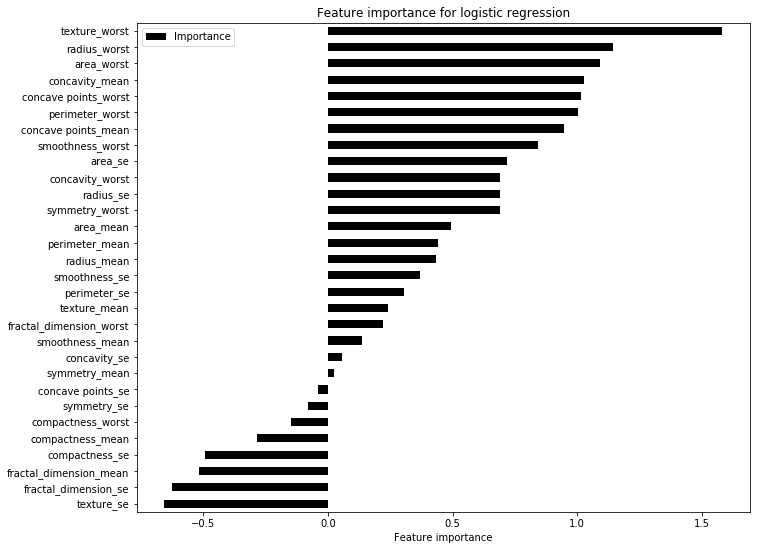

In [22]:
# feature importance
coefs = pd.DataFrame(logit.coef_.reshape((30, 1)), index = X_train.columns.tolist(), columns = ['Importance'])
coefs = coefs.sort_values(by='Importance', ascending=True)
coefs.plot(kind='barh', figsize=(11,9), color = 'black')
plt.xlabel('Feature importance')
plt.title('Feature importance for logistic regression')

### 2. random forest

In [24]:
# Perform grid search & fit model
rf = RandomForestClassifier(random_state = 33)

params = {
    'max_features': [3,4], # m = sqrt(M) for classification where M = 10
    'n_estimators': [4,5,6,7,10], #number of trees in the forest
    'max_depth': [4,5,6,7], #depth of the forest
    'min_samples_leaf': [1,2,3]
}

rf_PCA = GridSearchCV(estimator = rf, param_grid = params, scoring=None, n_jobs=3, 
                        iid=True, refit=True, cv=5, verbose=0, pre_dispatch='2*n_jobs', 
                        error_score='raise', return_train_score='warn');

rf_PCA.fit(X_train_PCA, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=33,
                              

In [25]:
# Look at hyperparameters - table
gridsearch_df_rf = pd.DataFrame(rf_PCA.cv_results_).sort_values("rank_test_score", ascending=True)
gridsearch_df_rf = gridsearch_df_rf[["param_max_depth", "param_max_features", "param_n_estimators", "param_min_samples_leaf", "mean_test_score"]].reset_index()
gridsearch_df_rf = gridsearch_df_rf.drop(["index"], axis=1)
gridsearch_df_rf.index = gridsearch_df_rf.index+1
gridsearch_df_rf.head(5)

,param_max_depth,param_max_features,param_n_estimators,param_min_samples_leaf,mean_test_score
1,4,3,4,1,0.953846
2,7,3,10,1,0.945055
3,4,3,5,1,0.940659
4,6,3,10,1,0.940659
5,4,3,4,2,0.940659


Text(0.5, 0, 'Number of trees to build random forest')

Text(0, 0.5, 'Average testing score')

Text(0.5, 1.0, 'Average testing score according to the number of estimators')

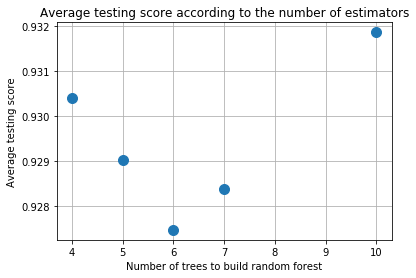

In [27]:
# Look at hyperparameters - plot (can change parameter to visualise as needed)
plt.plot(gridsearch_df_rf[['mean_test_score', 'param_n_estimators']].groupby('param_n_estimators').mean(), 
         marker='o', linestyle='None', markersize = 10.0)
plt.xlabel('Number of trees to build random forest')
plt.ylabel('Average testing score')
plt.title('Average testing score according to the number of estimators')
plt.grid()

In [28]:
# Make predictions
pred_rf_PCA = rf_PCA.predict(X_test_PCA)
proba_rf_PCA = rf_PCA.predict_proba(X_test_PCA)

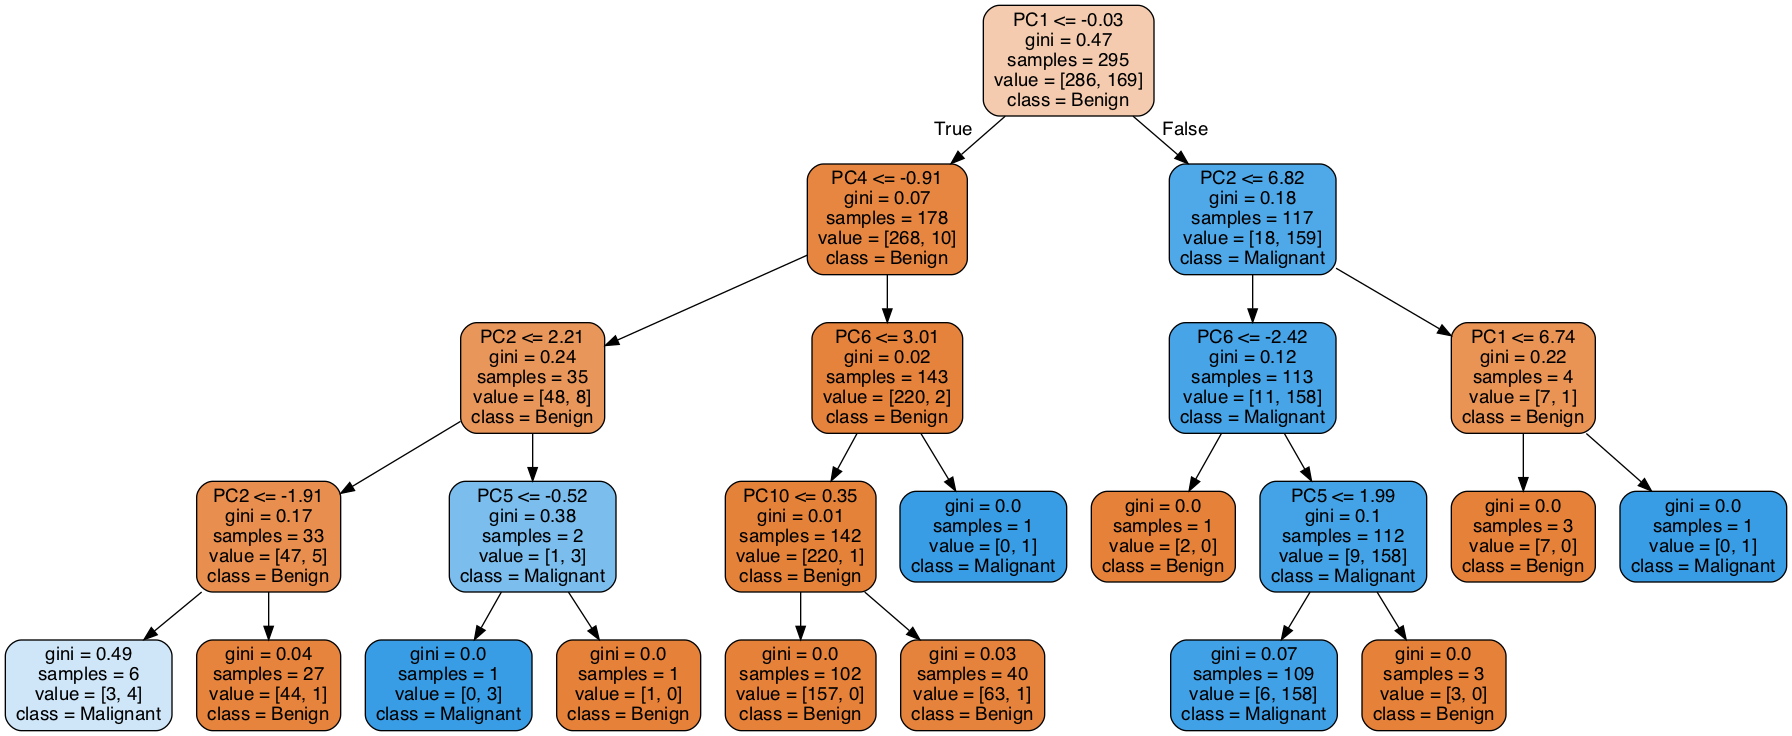

In [31]:
# Plot one of the trees
clf_rf = rf_PCA.best_estimator_
estimator = clf_rf.estimators_[1] 

# for a different example tree:
# estimator = clf_rf.estimators_[2]

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = features_pca,
                class_names = ['Benign','Malignant'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Display in jupyter notebook
(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

Image(filename = 'tree.png')

### 3. SVC (Support Vector Classification)
- finds a hyperplane in an N-dimensional space that distinctly classifies the data points
- ie) for 2 classes: draws a straight line and labels all the data points that fall on one side of the line as one class, all the points that fall on the other side labeled as another class

In [33]:
# Perform grid search & fit model
svc = SVC(gamma='auto', random_state=33, probability=True)

params = {
    'C':[1,2,3,4,5,6],
    'kernel':['rbf','linear']}

svc_PCA = GridSearchCV(estimator = svc, param_grid = params, cv=5);
svc_PCA.fit(X_train_PCA, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=True, random_state=33, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 2, 3, 4, 5, 6], 'kernel': ['rbf', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [35]:
# hyperparameters
gridsearch_df_svm = pd.DataFrame(svc_PCA.cv_results_).sort_values("rank_test_score", ascending=True)
gridsearch_df_svm = gridsearch_df_svm[["param_C", "param_kernel", "mean_test_score"]].reset_index()
gridsearch_df_svm = gridsearch_df_svm.drop(["index"], axis=1)
gridsearch_df_svm.index = gridsearch_df_svm.index+1
gridsearch_df_svm.head(5)

,param_C,param_kernel,mean_test_score
1,1,linear,0.973626
2,2,rbf,0.969231
3,3,rbf,0.969231
4,1,rbf,0.967033
5,2,linear,0.967033


In [36]:
# Make predictions
pred_svc_PCA = svc_PCA.predict(X_test_PCA)
proba_svc_PCA = svc_PCA.predict_proba(X_test_PCA)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=False, random_state=33, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 2, 3, 4, 5, 6], 'kernel': ['rbf', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

<Figure size 1080x720 with 0 Axes>

Text(0.5, 0, 'PC1')

Text(0, 0.5, 'PC2')

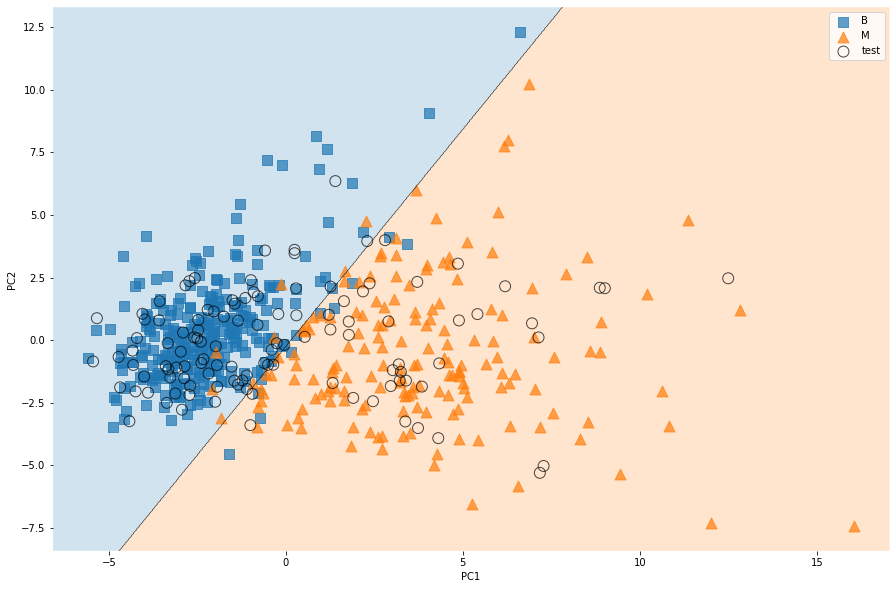

In [37]:
# Visualisation of SVC decision boundary using 2 PCs
X_train_subset = X_train_PCA[:,0:2]
X_test_subset = X_test_PCA[:,0:2]

svm_grid2 = GridSearchCV(SVC(gamma="auto", random_state = 33), {
    'C':[1,2,3,4,5,6],
    'kernel':['rbf','linear']},
     cv=5)

svm_grid2.fit(X_train_subset, y_train)
clf_svm_subset = svm_grid2.best_estimator_

scatter_kwargs = {'s': 120, 'edgecolor': None, 'alpha': 0.7}
contourf_kwargs = {'alpha': 0.2}
scatter_highlight_kwargs = {'s': 120, 'label': 'Test data', 'alpha': 0.7}
# Plotting decision regions
plt.figure(figsize = (15,10))
f = plot_decision_regions(X_train_subset, y_train.values, clf=clf_svm_subset,
                      X_highlight=X_test_subset,
                      scatter_kwargs=scatter_kwargs,
                      contourf_kwargs=contourf_kwargs,
                      scatter_highlight_kwargs=scatter_highlight_kwargs)

plt.xlabel('PC1')
plt.ylabel('PC2')
handles, labels = f.get_legend_handles_labels()
f.legend(handles,['B', 'M', 'test'])

<Figure size 1080x720 with 0 Axes>

Text(0.5, 0, 'PC1')

Text(0, 0.5, 'PC2')

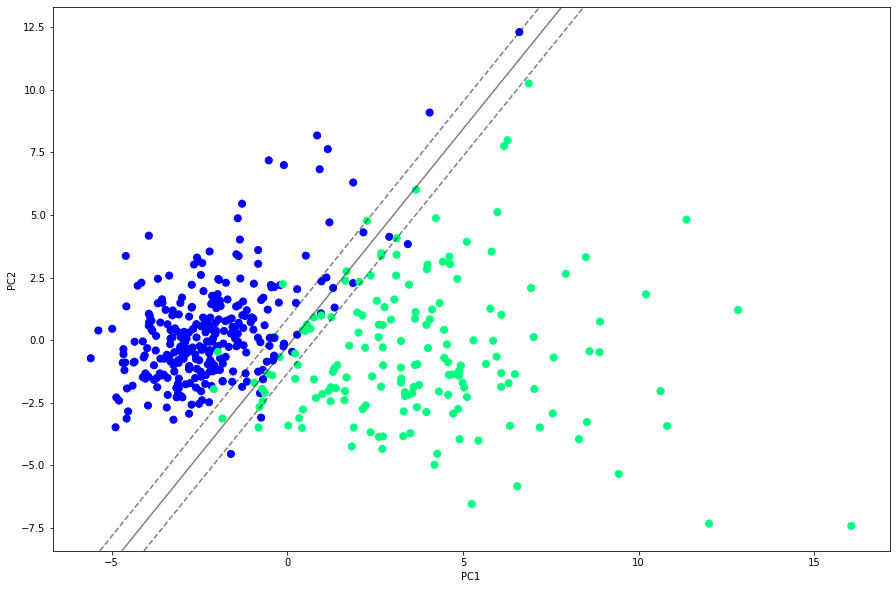

In [38]:
# # Visualisation of SVC decision boundary using 2 PCs - alternative version which doesn't use plot_decision_regions
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


plt.figure(figsize = (15,10))
plt.scatter(X_train_subset[:,0], X_train_subset[:,1], c=y_train, s=50, cmap='winter')
plot_svc_decision_function(clf_svm_subset)
plt.xlabel('PC1')
plt.ylabel('PC2')

### 4. KNN (K-Nearest Neighbours)
- classifies based on proximity between data points

In [39]:
# Perform grid search & fit model
knn = KNeighborsClassifier()

params = {'n_neighbors':[3,5,7,9,11,13,15,17],
          'weights':['uniform', 'distance'],
          'metric':['minkowski','euclidean', 'manhattan']}

knn_grid = GridSearchCV(estimator = knn, param_grid = params, scoring=None, n_jobs=3, 
                        iid=True, refit=True, cv=5, verbose=0, pre_dispatch='2*n_jobs', 
                        error_score='raise', return_train_score='warn');

knn_grid.fit(X_train_PCA, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=True, n_jobs=3,
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
             scoring=None, verbose=0)

In [40]:
# Hyperparameters - table
gridsearch_df_knn = pd.DataFrame(knn_grid.cv_results_).sort_values("rank_test_score", ascending=True)
gridsearch_df_knn = gridsearch_df_knn[["param_n_neighbors", "param_weights", "param_metric","mean_test_score"]].reset_index()
gridsearch_df_knn = gridsearch_df_knn.drop(["index"], axis=1)
gridsearch_df_knn.index = gridsearch_df_knn.index+1
gridsearch_df_knn.head(5)

,param_n_neighbors,param_weights,param_metric,mean_test_score
1,11,distance,minkowski,0.962637
2,11,distance,euclidean,0.962637
3,13,distance,euclidean,0.960440
4,9,distance,manhattan,0.960440
5,15,uniform,euclidean,0.960440


Text(0.5, 0, 'Number of Neighbours')

Text(0, 0.5, 'Average testing score')

Text(0.5, 1.0, 'Average testing score according to the number of neighbours')

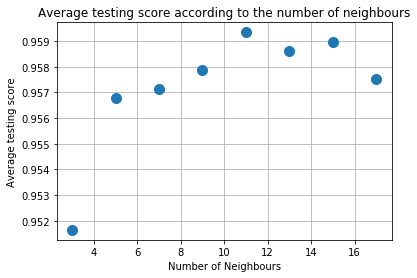

In [41]:
# Hyperparameter (k) - plot
plt.plot(gridsearch_df_knn[['mean_test_score', 'param_n_neighbors']].groupby('param_n_neighbors').mean(),
         marker='o', linestyle='None', markersize = 10.0)
plt.xlabel('Number of Neighbours')
plt.ylabel('Average testing score')
plt.title('Average testing score according to the number of neighbours')
plt.grid()

In [42]:
# Make predictions
pred_knn_PCA = knn_grid.predict(X_test_PCA)
proba_knn_PCA = knn_grid.predict_proba(X_test_PCA)

GridSearchCV(cv=5, error_score='raise',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=True, n_jobs=3,
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
             scoring=None, verbose=0)

<Figure size 1080x720 with 0 Axes>

Text(0.5, 0, 'PC1')

Text(0, 0.5, 'PC2')

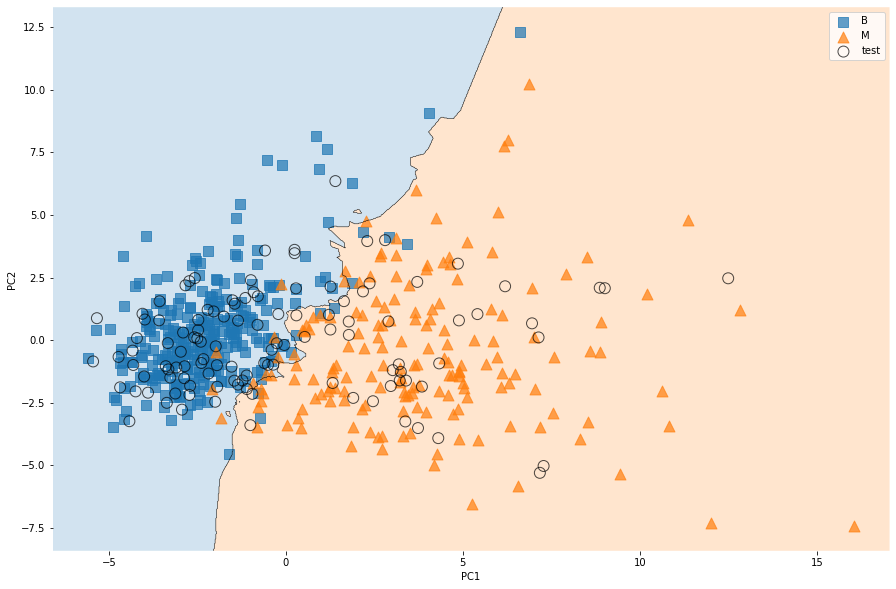

In [43]:
# Visualisation of SVC decision boundary using 2 PCs
knn_grid2 = GridSearchCV(estimator = knn, param_grid = params, scoring=None, n_jobs=3, 
                        iid=True, refit=True, cv=5, verbose=0, pre_dispatch='2*n_jobs', 
                        error_score='raise', return_train_score='warn');

knn_grid2.fit(X_train_subset, y_train)

knn_subset = knn_grid2.best_estimator_

scatter_kwargs = {'s': 120, 'edgecolor': None, 'alpha': 0.7}
contourf_kwargs = {'alpha': 0.2}
scatter_highlight_kwargs = {'s': 120, 'label': 'Test data', 'alpha': 0.7}
# Plotting decision regions
plt.figure(figsize = (15,10))
f = plot_decision_regions(X_train_subset, y_train.values, clf=knn_subset,
                      X_highlight=X_test_subset,
                      scatter_kwargs=scatter_kwargs,
                      contourf_kwargs=contourf_kwargs,
                      scatter_highlight_kwargs=scatter_highlight_kwargs)

plt.xlabel('PC1')
plt.ylabel('PC2')
handles, labels = f.get_legend_handles_labels()
f.legend(handles,['B', 'M', 'test'])

## Evaluation of all models

In [46]:
def evaluate(y_test,predicted,predicted_prob,model_name):
    cm = confusion_matrix(y_test, predicted)
    accuracy = accuracy_score(y_test, predicted)
    precision = precision_score(y_test, predicted)
    auc = roc_auc_score(y_test, predicted_prob)
    report = classification_report(y_test,predicted)

    print("Model: " + model_name)
    print("Confusion matrix:")
    print(cm)
    print("Accuracy: %s" % "{0:.1%}".format(accuracy))
    print("Precision: %s" % "{0:.1%}".format(precision))
    print("AUC: %.3f" %auc)
    print("report: ")
    print(report)

#logit_eval = evaluate(y_test, pred_logit, (proba_logit[:,1]), 'logistic regression without PCA')
logit_PCA_eval = evaluate(y_test, pred_logit_PCA, (proba_logit_PCA[:,1]), 'logistic regression')
rf_PCA_eval = evaluate(y_test, pred_rf_PCA, proba_rf_PCA[:,1], 'random forest')
svc_PCA_eval = evaluate(y_test, pred_svc_PCA, proba_svc_PCA[:,1], 'SVC')
knn_PCA_eval = evaluate(y_test, pred_knn_PCA, proba_knn_PCA[:,1], 'KNN')

Model: logistic regression
Confusion matrix:
[[71  0]
 [ 2 41]]
Accuracy: 98.2%
Precision: 100.0%
AUC: 0.986
report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Model: random forest
Confusion matrix:
[[66  5]
 [ 5 38]]
Accuracy: 91.2%
Precision: 88.4%
AUC: 0.972
report: 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        71
           1       0.88      0.88      0.88        43

    accuracy                           0.91       114
   macro avg       0.91      0.91      0.91       114
weighted avg       0.91      0.91      0.91       114

Model: SVC
Confusion matrix:
[[71  0]
 [ 3 40]]
Accuracy: 97.4%
Precision: 100.0%
AUC: 0.986
report: 
              p

Text(0.5, 0, 'False positive rate')

Text(0, 0.5, 'True positive rate')

Text(0.5, 1.0, 'ROC')

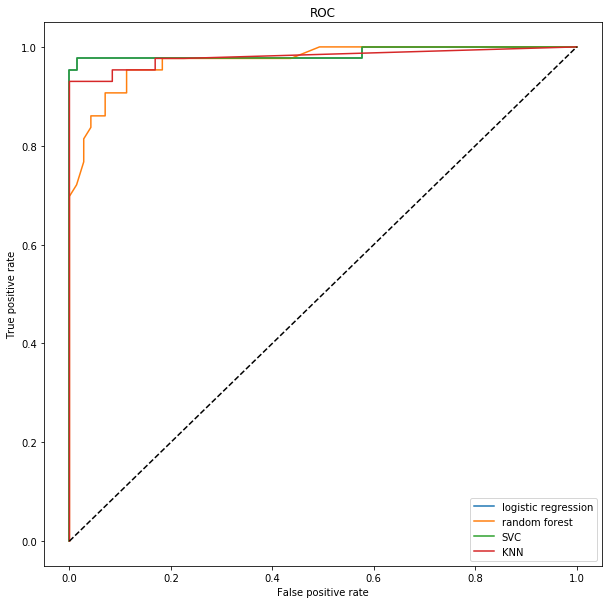

In [45]:
# Plot ROCs
prob_all = proba_logit_PCA, proba_rf_PCA, proba_svc_PCA, proba_knn_PCA
model_name = ["logistic regression", "random forest", "SVC", "KNN"]

fig = plt.figure(figsize=(10,10))
for i in range(4):
    fpr, tpr, thresholds = roc_curve(y_test,prob_all[i][:,1])
    plt.plot(fpr, tpr, label=model_name[i])

plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')

### Conclusions
- PCA improves performance with logistic regression
- logistic regression (with PCA) & SVC seem to be the best

### Factors to consider
- small dataset (569 observations)
- bias in the dataset towards benign (62.7%)
- didn't handle outliers during pre-processing (but perhaps not necessary as the original paper mentioned that extreme values of area, texture & smoothness were the most important features in predicting)

### Additional things to look at
- comparison of all models with PCA vs without PCA
- correlation between the features & PCs
- other classification models: ex) naive Bayes, neural networks etc